# Utqiagvik **Fall Wind Speed** Analysis
- Bowhead whale hunting happens in fall (September, October, November) and is dependent on ocean/wind conditions
- Notebook by Alice DuVivier (NCAR)
- January 2026

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## Load Near Surface Wind Speed Data

### Load Barrow Observatory Data
- if a leap year, drop the leap day: 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, and 2024
- to look at a particular row, use iloc: df.iloc[1416]
- 2016 is missing data

In [2]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/NOAA_GML_BRW_MET/'

In [3]:
# years from 1974-2024
years_obs = np.arange(1974,2025,1)
nyrs_obs = len(years_obs)
print(nyrs_obs)

51


In [4]:
# preallocate some arrays
avg_array = np.zeros([nyrs_obs,365])

# loop through each year to get the data and calculate annual average
for index, yy in enumerate(years_obs):
    #print(yy)
    file_in = 'brw_met_'+str(yy)+'.csv'
    #print(file_in)
    # load data with pandas
    df = pd.read_csv(dir_in+file_in)
    # rename columns to work with datetime
    df = df.rename(columns={'YYYY':'year','MM':'month', 'DD':'day','HH':'hour'})
    # create datetime from time data
    df['date_col'] = pd.to_datetime(df[['year','month','day','hour']])
    # set new date column as index
    df = df.set_index('date_col')     
    # read just the wind speed values
    temp1 = df['WndSpd']
    # replace missing values (-99.9) with NaN and put this into an array
    temp2 = temp1.where(temp1> -99.9)
    # create daily averages
    temp3 = temp2.resample('D').mean() 
    # if a leap year, remove leap day hours
    if (yy==1976)or(yy==1980)or(yy==1984)or(yy==1988)or(yy==1992)or(yy==1996)or(yy==2000)or(yy==2004)or(yy==2008)or(yy==2012)or(yy==2016)or(yy==2020)or(yy==2024):
        print(str(yy)+': Leap year - removing leapday')
        dstr = str(yy)+'-02-29'
        temp3 = temp3.drop(pd.Timestamp(dstr))
    # look at dates for the series
    #dates = temp3.index.to_series()
    # fill array with this data
    avg_array[index,:] = temp3

# convert the numpy arrays to xarrays for easier plotting
data_obs = xr.DataArray(avg_array,dims=('years','doy'))
data_obs['years'] = years_obs

1976: Leap year - removing leapday
1980: Leap year - removing leapday
1984: Leap year - removing leapday
1988: Leap year - removing leapday
1992: Leap year - removing leapday
1996: Leap year - removing leapday
2000: Leap year - removing leapday
2004: Leap year - removing leapday
2008: Leap year - removing leapday
2012: Leap year - removing leapday
2016: Leap year - removing leapday
2020: Leap year - removing leapday
2024: Leap year - removing leapday


<xarray.DataArray ()> Size: 8B
array(95.20416667)


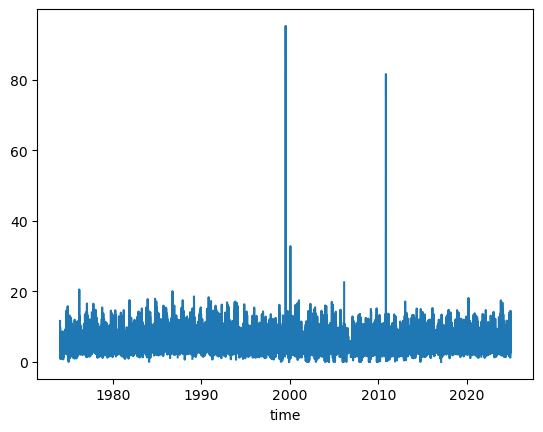

In [5]:
# actually want all data in one array
data_obs_all = data_obs.stack(time=("years", "doy"))

# make array of the dates
daily_dates = pd.date_range(start="1974-01-01", end="2024-12-31", freq="D")
# remove leap days
filtered_dates = daily_dates[~((daily_dates.month == 2) & (daily_dates.day == 29))]

# reassign the time array
data_obs_all['time'] = filtered_dates

# look at data quickly
print(data_obs_all.max())
data_obs_all.plot()

### Load CESM2-LE data
- Load both WSPDSRFAV and U10 to compare
- Also load WSPDSRFMX for gustiness info

In [6]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/cesm2-le_utqiagvik/'
file_in = 'Utqiagvik_CESM2-LE_1920-2100_daily-WSPDSRFAV.nc'

ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [7]:
# look at dataset
ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1920', end='12/31/2100', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(66065,)


In [8]:
data_cesm2le = ds.WSPDSRFAV

In [9]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/cesm2-le_utqiagvik/'
file_in = 'Utqiagvik_CESM2-LE_1920-2100_daily-U10.nc'

ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [10]:
# look at dataset
ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1920', end='12/31/2100', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(66065,)


In [11]:
data_cesm2le_u10 = ds.U10

In [12]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/cesm2-le_utqiagvik/'
file_in = 'Utqiagvik_CESM2-LE_1920-2100_daily-WSPDSRFMX.nc'

ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [13]:
# look at dataset
ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1920', end='12/31/2100', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(66065,)


In [14]:
data_cesm2le_max = ds.WSPDSRFMX

## Process Fall Wind Speed data - Model
- September, October, November only
- Timeseries: calculate means and standard deviations over spring months
- Time of Emergence: Use baseline 51 years (1925-1975). ToE happens when Ens.Mean drops below the +/-2 STD from baseline period
- Fractions below some thresholds

In [15]:
# get some dimensions

# years from 1920-2100
years_model = np.arange(1920,2101,1)
nyrs = len(years_model)
print(nyrs)

# total ensemble members
nens_cesm2le = len(data_cesm2le.member_id)
print(nens_cesm2le)

181
50


In [16]:
# days are all days in Sept, Oct, Nov
ndays = 30 + 31 + 30

In [17]:
# subset to just this season

# CESM2-LE
data_cesm2le_seas = data_cesm2le.isel(time=data_cesm2le.time.dt.month.isin([9,10,11]))
data_cesm2le_u10_seas = data_cesm2le_u10.isel(time=data_cesm2le_u10.time.dt.month.isin([9,10,11]))
data_cesm2le_max_seas = data_cesm2le_max.isel(time=data_cesm2le_max.time.dt.month.isin([9,10,11]))

# Observations
data_obs_seas = data_obs_all.isel(time=data_obs_all.time.dt.month.isin([9,10,11]))

### Means

In [18]:
# Observations
# preallocate some arrays
avg_array = np.zeros([nyrs_obs])
std_array = np.zeros([nyrs_obs])

# loop through each year to get the data
for index, yy in enumerate(years_obs):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_obs_seas.isel(time=data_obs_seas.time.dt.year.isin([yy]))
    # calculate mean
    avg_array[index] = temp1.mean(dim='time')
    # calculate standard deviation
    std_array[index] = temp1.std(dim='time')

# convert the numpy arrays to xarrays for easier plotting
obs_avg = xr.DataArray(avg_array,dims=('years'))
obs_avg['years'] = years_obs
obs_std = xr.DataArray(std_array,dims=('years'))
obs_std['years'] = years_obs

In [19]:
# CESM2-LE
data_model = data_cesm2le_seas

# preallocate some arrays
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d
    temp2 = temp1.stack(all=("member_id","time"))
    # calculate mean
    avg_array[index] = temp2.mean(dim='all')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='all')

# convert the numpy arrays to xarrays for easier plotting
cesm2le_avg = xr.DataArray(avg_array,dims=('years'))
cesm2le_avg['years'] = years_model
cesm2le_std = xr.DataArray(std_array,dims=('years'))
cesm2le_std['years'] = years_model

In [20]:
# CESM2-LE - U10
data_model = data_cesm2le_u10_seas

# preallocate some arrays
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d
    temp2 = temp1.stack(all=("member_id","time"))
    # calculate mean
    avg_array[index] = temp2.mean(dim='all')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='all')

# convert the numpy arrays to xarrays for easier plotting
cesm2le_u10_avg = xr.DataArray(avg_array,dims=('years'))
cesm2le_u10_avg['years'] = years_model
cesm2le_u10_std = xr.DataArray(std_array,dims=('years'))
cesm2le_u10_std['years'] = years_model

In [21]:
# CESM2-LE - MAX wind
data_model = data_cesm2le_max_seas

# preallocate some arrays
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d
    temp2 = temp1.stack(all=("member_id","time"))
    # calculate mean
    avg_array[index] = temp2.mean(dim='all')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='all')

# convert the numpy arrays to xarrays for easier plotting
cesm2le_max_avg = xr.DataArray(avg_array,dims=('years'))
cesm2le_max_avg['years'] = years_model
cesm2le_max_std = xr.DataArray(std_array,dims=('years'))
cesm2le_max_std['years'] = years_model

### Time of Emergence
- For baseline, use 50 years: 1925-1975
- ToE happens when Ens.Mean drops below the +/-2 STD from baseline period

In [22]:
# subset data to just 1925-1975
yy_sub = np.arange(1925,1976,1)

In [23]:
# CESM2-LE
data_model = data_cesm2le_seas
model_avg = cesm2le_avg

### Get baseline means and standard deviation
# subset years
data_model_sub = data_model.isel(time=data_model.time.dt.year.isin([yy_sub]))
# stack into one dimension
data_model_sub_1d = data_model_sub.stack(all=("member_id","time"))
# calculate mean and standard deviation over all these points
avg_baseline = data_model_sub_1d.mean(dim='all')
print(avg_baseline.values)
std_baseline = data_model_sub_1d.std(dim='all')
print(std_baseline.values)

### Find TOE
# When Ens.Mean falls **below** baseline mean **minus** 2STD
toe_thresh_hi = avg_baseline + 2*std_baseline
toe_thresh_low = avg_baseline - 2*std_baseline
# make xarray of where the output has emerged
emerged = model_avg < toe_thresh_low.values
# Check if there is a ToE
is_all_false = (emerged == False).all()
# If there is a ToE, calculate the index where it happens
if is_all_false == False:
    print('ToE exists, calculating index')
    ToE_flag = True
    first_index = emerged.argmax(dim='years')
    # calculate x and y for plot
    x_toe = emerged[first_index].years.values
    y_toe = model_avg[first_index].values
    # print the year of ToE
    print(x_toe)
else:
    print('No ToE exists')
    ToE_flag = False
    x_toe = np.full((1, 1), np.nan)
    y_toe = np.full((1, 1), np.nan)

### Write variables
cesm2le_x_toe = x_toe
cesm2le_y_toe = y_toe
cesm2le_toe_thresh_hi = toe_thresh_hi.values
cesm2le_toe_thresh_low = toe_thresh_low.values

8.581725
3.8391683
No ToE exists


In [24]:
# CESM2-LE - U10
data_model = data_cesm2le_u10_seas
model_avg = cesm2le_u10_avg

### Get baseline means and standard deviation
# subset years
data_model_sub = data_model.isel(time=data_model.time.dt.year.isin([yy_sub]))
# stack into one dimension
data_model_sub_1d = data_model_sub.stack(all=("member_id","time"))
# calculate mean and standard deviation over all these points
avg_baseline = data_model_sub_1d.mean(dim='all')
print(avg_baseline.values)
std_baseline = data_model_sub_1d.std(dim='all')
print(std_baseline.values)

### Find TOE
# When Ens.Mean falls **below** baseline mean **minus** 2STD
toe_thresh_hi = avg_baseline + 2*std_baseline
toe_thresh_low = avg_baseline - 2*std_baseline
# make xarray of where the output has emerged
emerged = model_avg < toe_thresh_low.values
# Check if there is a ToE
is_all_false = (emerged == False).all()
# If there is a ToE, calculate the index where it happens
if is_all_false == False:
    print('ToE exists, calculating index')
    ToE_flag = True
    first_index = emerged.argmax(dim='years')
    # calculate x and y for plot
    x_toe = emerged[first_index].years.values
    y_toe = model_avg[first_index].values
    # print the year of ToE
    print(x_toe)
else:
    print('No ToE exists')
    ToE_flag = False
    x_toe = np.full((1, 1), np.nan)
    y_toe = np.full((1, 1), np.nan)

### Write variables
cesm2le_u10_x_toe = x_toe
cesm2le_u10_y_toe = y_toe
cesm2le_u10_toe_thresh_hi = toe_thresh_hi.values
cesm2le_u10_toe_thresh_low = toe_thresh_low.values

7.59539
3.3290465
No ToE exists


In [25]:
# CESM2-LE - max
data_model = data_cesm2le_max_seas
model_avg = cesm2le_max_avg

### Get baseline means and standard deviation
# subset years
data_model_sub = data_model.isel(time=data_model.time.dt.year.isin([yy_sub]))
# stack into one dimension
data_model_sub_1d = data_model_sub.stack(all=("member_id","time"))
# calculate mean and standard deviation over all these points
avg_baseline = data_model_sub_1d.mean(dim='all')
print(avg_baseline.values)
std_baseline = data_model_sub_1d.std(dim='all')
print(std_baseline.values)

### Find TOE
# When Ens.Mean falls **below** baseline mean **minus** 2STD
toe_thresh_hi = avg_baseline + 2*std_baseline
toe_thresh_low = avg_baseline - 2*std_baseline
# make xarray of where the output has emerged
emerged = model_avg < toe_thresh_low.values
# Check if there is a ToE
is_all_false = (emerged == False).all()
# If there is a ToE, calculate the index where it happens
if is_all_false == False:
    print('ToE exists, calculating index')
    ToE_flag = True
    first_index = emerged.argmax(dim='years')
    # calculate x and y for plot
    x_toe = emerged[first_index].years.values
    y_toe = model_avg[first_index].values
    # print the year of ToE
    print(x_toe)
else:
    print('No ToE exists')
    ToE_flag = False
    x_toe = np.full((1, 1), np.nan)
    y_toe = np.full((1, 1), np.nan)

### Write variables
cesm2le_max_x_toe = x_toe
cesm2le_max_y_toe = y_toe
cesm2le_max_toe_thresh_hi = toe_thresh_hi.values
cesm2le_max_toe_thresh_low = toe_thresh_low.values

10.815942
4.104904
No ToE exists


## Plot timeseries

In [26]:
# set an output directory for figures
dir_out = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/utqiagvik_analysis/version_5/'

### All Models on one Plot

In [27]:
# set legend font size
fs = 15

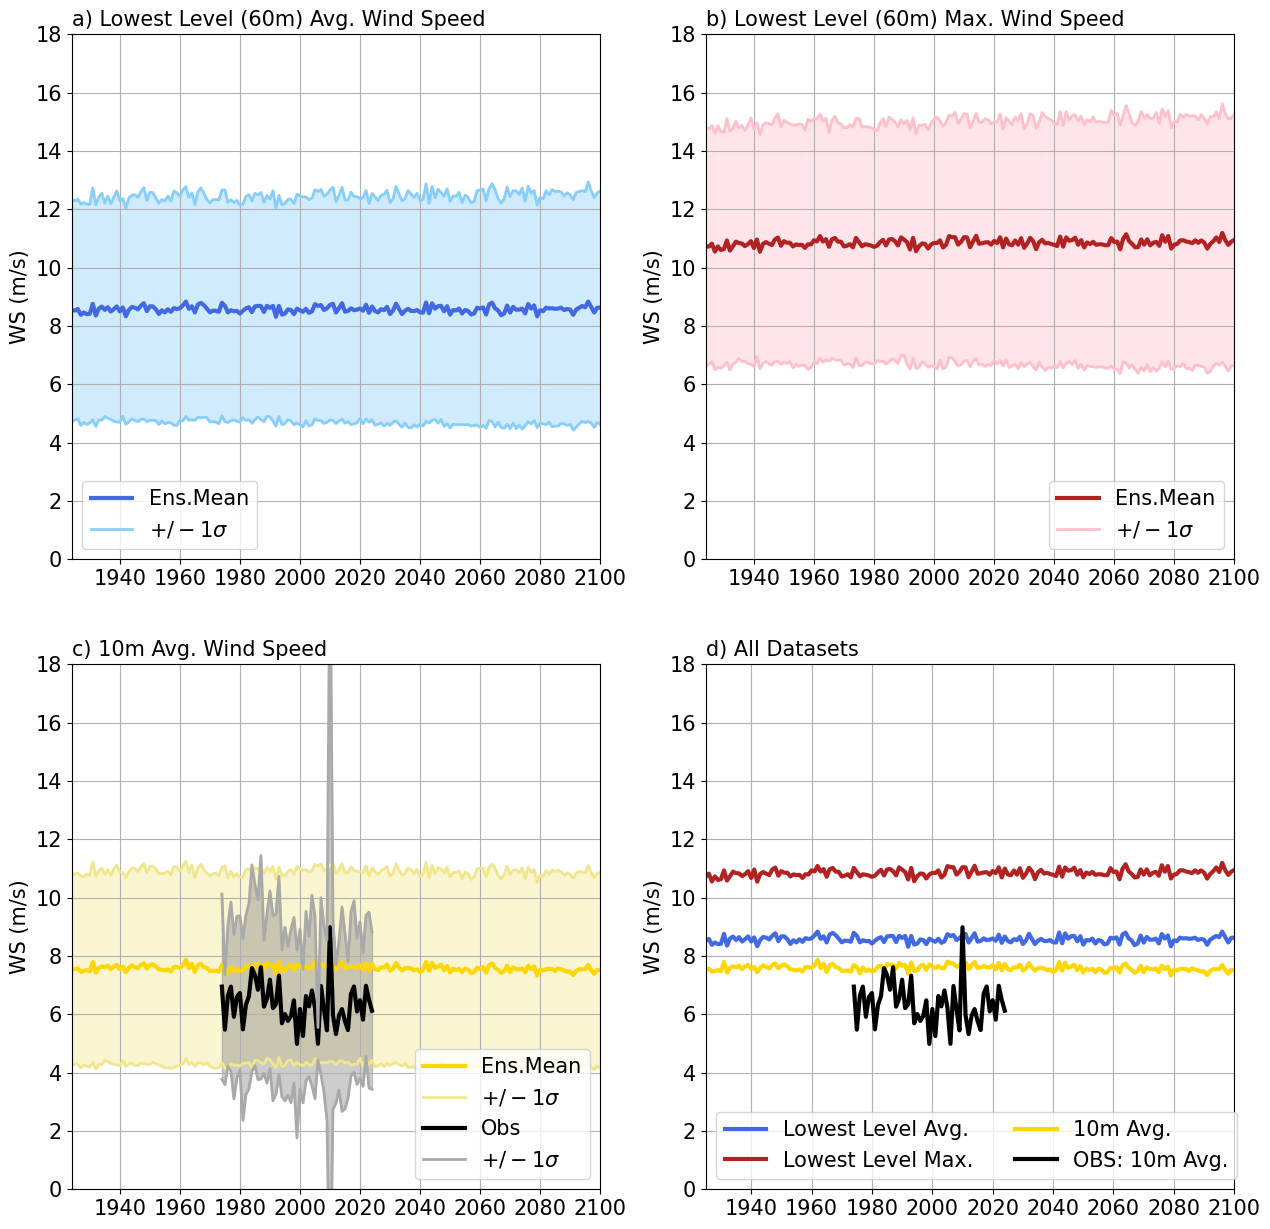

In [36]:
# create figure
fig = plt.figure(figsize=(15,15))
# now loop through months to create subpanels
fout = 'sfig_2_utq_fall_ws_timeseries_all'

# Make subplot - note it's nrow x ncol x index (starting upper left)
### Plot 1 ###
ax = fig.add_subplot(2,2,1)
# for this model, set data
data_avg = cesm2le_avg
data_std = cesm2le_std
## Model Data
ax.plot(years_model,data_avg,color='royalblue',label='Ens.Mean',linestyle='-',linewidth=3)
ax.plot(years_model,data_avg-data_std,color='lightskyblue',label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,data_avg+data_std,color='lightskyblue',linestyle='-',linewidth=2)
plt.fill_between(years_model, data_avg, data_avg+data_std, color='lightskyblue', alpha=0.4)
plt.fill_between(years_model, data_avg, data_avg-data_std, color='lightskyblue', alpha=0.4)
# modify labels and legend
plt.title('a) Lowest Level (60m) Avg. Wind Speed',loc='left',fontsize=fs)
#plt.xlabel('year',fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlim([1924,2100])
plt.ylabel('WS (m/s)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim([0,18.0])
plt.grid()
plt.legend(loc='lower left', fontsize=fs, ncol=1)

### Plot 2 ###
ax = fig.add_subplot(2,2,2)
# for this model, set data
data_avg = cesm2le_max_avg
data_std = cesm2le_max_std
## Model Data
ax.plot(years_model,data_avg,color='firebrick',label='Ens.Mean',linestyle='-',linewidth=3)
ax.plot(years_model,data_avg-data_std,color='pink',label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,data_avg+data_std,color='pink',linestyle='-',linewidth=2)
plt.fill_between(years_model, data_avg, data_avg+data_std, color='pink', alpha=0.4)
plt.fill_between(years_model, data_avg, data_avg-data_std, color='pink', alpha=0.4)
# modify labels and legend
plt.title('b) Lowest Level (60m) Max. Wind Speed',loc='left',fontsize=fs)
#plt.xlabel('year',fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlim([1924,2100])
plt.ylabel('WS (m/s)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim([0,18.0])
plt.grid()
plt.legend(loc='lower right', fontsize=fs, ncol=1)

### Plot 3 ###
ax = fig.add_subplot(2,2,3)
# for this model, set data
data_avg = cesm2le_u10_avg
data_std = cesm2le_u10_std
## Model Data
ax.plot(years_model,data_avg,color='gold',label='Ens.Mean',linestyle='-',linewidth=3)
ax.plot(years_model,data_avg-data_std,color='khaki',label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,data_avg+data_std,color='khaki',linestyle='-',linewidth=2)
plt.fill_between(years_model, data_avg, data_avg+data_std, color='khaki', alpha=0.4)
plt.fill_between(years_model, data_avg, data_avg-data_std, color='khaki', alpha=0.4)
## Obs Data
ax.plot(years_obs,obs_avg,color='black',label='Obs',linestyle='-',linewidth=3)
ax.plot(years_obs,obs_avg-obs_std,color='darkgrey',label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_obs,obs_avg+obs_std,color='darkgrey',linestyle='-',linewidth=2)
plt.fill_between(years_obs, obs_avg, obs_avg+obs_std, color='grey', alpha=0.4)
plt.fill_between(years_obs, obs_avg, obs_avg-obs_std, color='grey', alpha=0.4)
# modify labels and legend
plt.title('c) 10m Avg. Wind Speed',loc='left',fontsize=fs)
#plt.xlabel('year',fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlim([1924,2100])
plt.ylabel('WS (m/s)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim([0,18.0])
plt.grid()
plt.legend(loc='lower right', fontsize=fs, ncol=1)

### Plot 4 ###
ax = fig.add_subplot(2,2,4)
## CESM2-LE - LL
ax.plot(years_model,cesm2le_avg,color="royalblue",label='Lowest Level Avg.',linestyle='-',linewidth=3)
## CESM2-LE - LL
ax.plot(years_model,cesm2le_max_avg,color="firebrick",label='Lowest Level Max.',linestyle='-',linewidth=3)
## CESM2-LE - U10
ax.plot(years_model,cesm2le_u10_avg,color="gold",label='10m Avg.',linestyle='-',linewidth=3)
## Obs - U10
ax.plot(years_obs,obs_avg,color="black",label='OBS: 10m Avg.',linestyle='-',linewidth=3)
# modify labels and legend
plt.title('d) All Datasets',loc='left',fontsize=fs)
#plt.xlabel('year',fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlim([1925,2100])
plt.ylabel('WS (m/s)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim([0,18.0])
plt.grid()
plt.legend(loc='lower left', fontsize=fs, ncol=2)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)